# Predicting Hotel Booking Cancellations
## Modeling

## 1. Introduction

### 1.1 Problem statement

This is the fourth and last Jupiter notebook of my **Predicting Hotel Booking Cancellations** project. In this part we are creating Classification models using **SKLean** to model the data that was cleaned in the pre-processing steps, with the final goal to find the best model to predict future Hotel Bookings Cancelations.

Having this tool available will allow the company to target these specific clients before they cancel with different marketing campaigns.

With a wide diversity of Machine Learning models we will start with some simple one and then move to the Ensemble models.

We will adjust the hyper-parameters of these models to optimize them while taking into consideration overfitting, underfitting, and the bias-variance trade-off. 

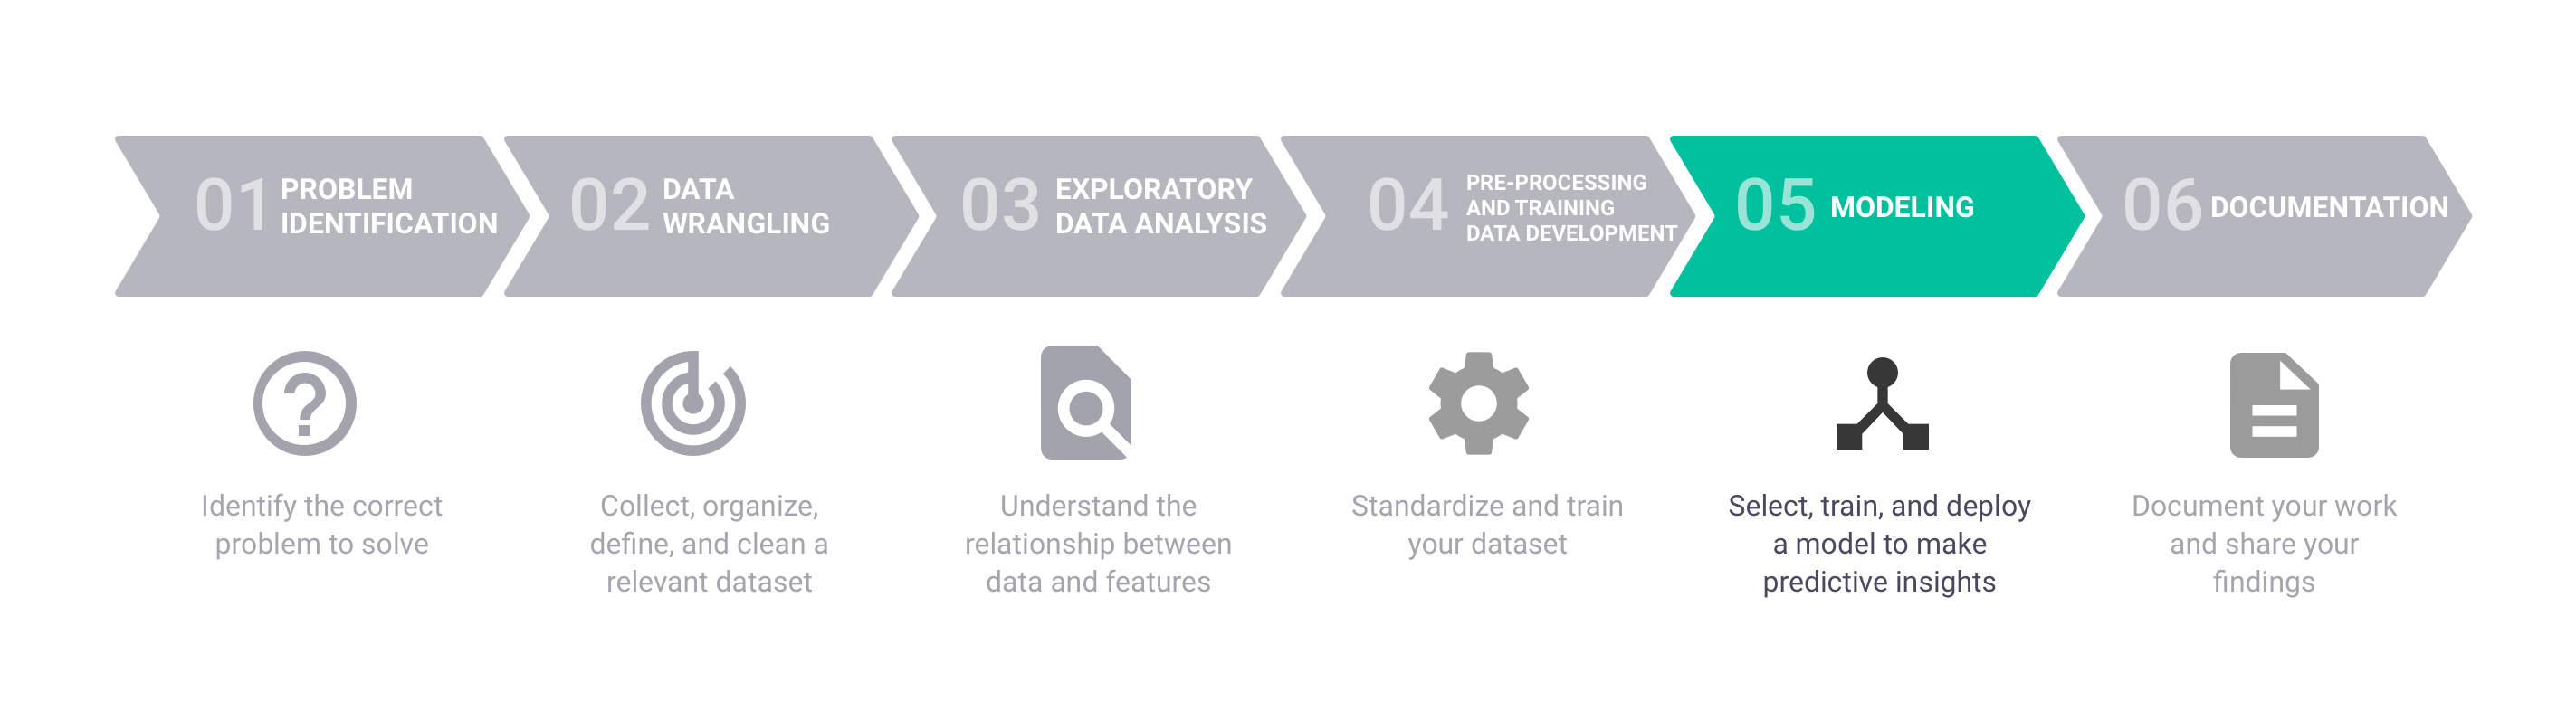

### 1.2 Metrics selection

An appropriate measurement will be **accuracy**, which gives the percentage of correct predictions, and **the area under the ROC curve** which measures how well the model can differentiate between classes. 

We will create a DataFrame to save the **scores for both training and test** sets so when we will make a decision on choosing the right model we can develop further analysis to identify models that are overfitting or underfitting on training data.

Beside the 2 mentioned metrics we will also print the **clasification report** containing information about **Recall** and **Precision** and we will plot the **normalized confusion matrix** and the **ROC curve**.

## 2. Data loading and final pre-processing

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
import seaborn as sns
sns.set_theme(style="darkgrid")
import os
import time
import pickle
import datetime
import shap
from sklearn import __version__ as sklearn_version
from scipy.stats import uniform
np.random.seed(123)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline


from catboost import CatBoostClassifier, Pool, metrics, cv

In [2]:
# Read in clean data
hotels = pd.read_csv('../data/interim/hotels_for_modeling.csv', index_col=0)

In [3]:
hotels['cust_segmentation'] = hotels['cust_segmentation'].astype('str')
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119388
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119389 non-null  object 
 1   is_canceled                     119389 non-null  int64  
 2   lead_time                       119389 non-null  int64  
 3   arrival_date_year               119389 non-null  int64  
 4   arrival_date_month              119389 non-null  int64  
 5   arrival_date_week_number        119389 non-null  int64  
 6   arrival_date_day_of_month       119389 non-null  int64  
 7   stays_in_weekend_nights         119389 non-null  int64  
 8   stays_in_week_nights            119389 non-null  int64  
 9   adults                          119389 non-null  int64  
 10  children                        119389 non-null  float64
 11  babies                          119389 non-null  int64  
 12  meal            

### 2.1 Dealing with categorical, train_test_split and scaling

Before exploring the models and the metrics we can use for our classification problem we need to make sure our data is ready for this step. For that we have to consider the types of classifiers we will be using: 

Algorithms that exploit distances or similarities (e.g. in the form of scalar product) between data samples, such as k-NN and SVM and that are sensitive to feature transformations and can't work with categorical data.

Graphical-model based classifiers, such as Fisher LDA or Naive Bayes, as well as Decision trees and Tree-based ensemble methods (RF, XGB) are invariant to feature scaling, and can work with categorical data.


> First let's get our target feature **y** and our predictive features **X**.

In [4]:
X = hotels.drop('is_canceled', axis=1)
        
y = hotels['is_canceled']
X.shape, y.shape

((119389, 31), (119389,))

> For **ordinal categorical data** we could use **LabelEncoder**, but since our categorical data is **nominal** we will use solely Panda's **get_dummies**.

In [5]:
X_dumm = pd.get_dummies(X, drop_first=True)
X_dumm.shape

(119389, 62)

> Now we will split our data in **train** and **test**.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size = 0.3)

> Finally we will apply sklearn's **StandardScaler**.

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 2.2 Defining useful functions

Now we will crate a few functions to help us:
* **plotting the ROC curve** and getting the **roc_auc score** for both Train and Test sets.
* getting the other Evaluation Metrics from our classification models:
     * **Accuracy** - for both Train and Test
     * **Classification report** - which includes the **F1 score, Recall** and **Precision** for both predicted classes.
     * **Confusion matrix** - normalized.

In [8]:
# plotting the ROC curve
def plot_ROC(model):
        global train_roc_score, test_roc_score
        
        y_pred_prob = model.predict_proba(X_test)[:,1]
        y_tr_pred_prob = model.predict_proba(X_train)[:,1]
        
        train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
        test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)
        
        print('Train - Area under ROC score: {}'.format(train_roc_score))
        print('Test - Area under ROC score: {}'.format(test_roc_score))
        
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob)
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_tr_pred_prob)
        plt.figure(figsize=(6,6))
        plt.plot(fpr_test, tpr_test, label = 'Test ROC', c = 'r')
        plt.plot(fpr_train, tpr_train, label = 'Train ROC', c = 'blue')
        plt.xlabel('True Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.title('{} ROC Curve'.format(model))
        

        plt.show()

In [9]:
def evaluation_block(model):
    global train_acc, test_acc
    
    y_tr_pred = model.predict(X_train)
    
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    
    print("Train - Accuracy:", train_acc)
    print("Test - Accuracy:", test_acc)
    print('Validation - Classification report\n', classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap = 'Blues')
    plt.show()

In [10]:
results = pd.DataFrame(columns = ['model','train_accuracy', 'test_accuracy', 'train_ROC', 'test_ROC'])
pd.set_option("max_colwidth", 100)
def save_scores(model):
    
    new_row = {'model':model,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_ROC': train_roc_score,
               'test_ROC': test_roc_score}
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

## 3. Logistic regression

### 3.1 Out of the Box Logistic regression

For this initial model we will use a simple out of the box model - LogisticRegression.

In [11]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

Train - Accuracy: 0.8211
Test - Accuracy: 0.8224
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

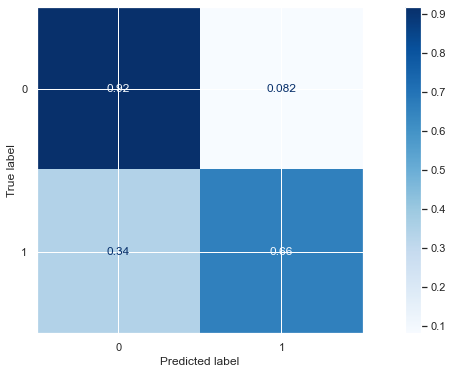

In [12]:
evaluation_block(logreg)

Train - Area under ROC score: 0.8761
Test - Area under ROC score: 0.8765


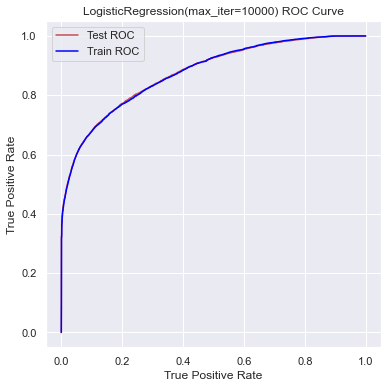

In [13]:
plot_ROC(logreg)

The score for the out of the box LogisticRegression model is: **0.8224 accuracy and 0.8765 AUROC score**.

In [14]:
save_scores(logreg)

In [15]:
results

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
0,LogisticRegression(max_iter=10000),0.8211,0.8224,0.8761,0.8765


### 3.2 Logistic regression with PCA

The out of the box model can be improved by either tunning the hyperparameters or by further modifing the data prior to applying the classifiers.

We will now see how PCA affects our LogisticRegression model.

In [16]:
pca = PCA()
pca.fit(X_train)

PCA()

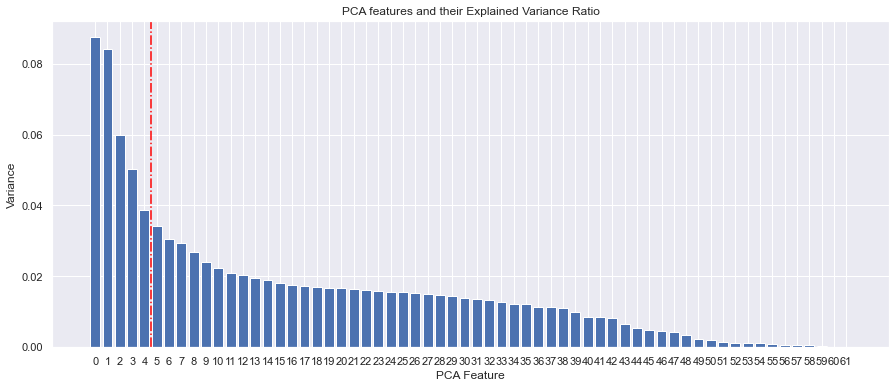

In [17]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.axvline(4.5, c = 'red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('PCA features and their Explained Variance Ratio')
plt.show()

Text(0.5, 1.0, 'Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

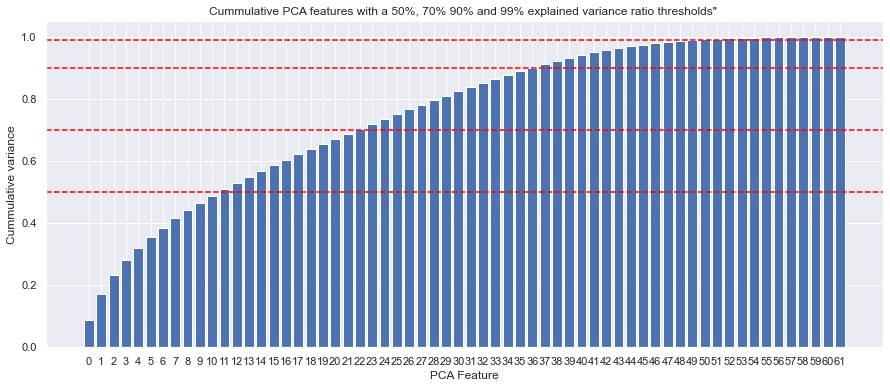

In [18]:
plt.bar(features, np.cumsum(pca.explained_variance_ratio_))
[plt.axhline(y=i, linestyle='--', c = 'red') for i in [.5,.7,.9, 0.99]]
plt.xticks(features)
plt.ylabel('Cummulative variance')
plt.xlabel('PCA Feature')
plt.title('Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

Based on our PCA decomposition we can choose the folowing number of principal components:
* 5 - for about 30% explained variance
* 11 - for >50% explained variance
* 22 - for >70% explained variance
* 37 - for >90% explained variance
* 50 - for >99% explained variance

Obviously we need to consider the fact that a model based on fewer features will be underfitting while one based on a lot of them will ussualy overfit. 

Another aspect when considering underfitting vs overfitting is the dataset size, and in this case the training data has 80k+ records, so considering we are dealing with a rather big dataset we can choose more features without a high risk of overfitting. And we can check that by comparing the metrics from our training set versus the scores our models produces on the test set.

---------------------Train & Test scores : Log reg model with 5 PCA features-------------------
Train - Accuracy:  0.6795
Test - Accuracy:  0.6841
Train - Area under ROC score: 0.6735 
Test - Area under ROC score: 0.6702 

              precision    recall  f1-score   support

           0       0.68      0.93      0.79     22691
           1       0.68      0.26      0.38     13126

    accuracy                           0.68     35817
   macro avg       0.68      0.59      0.58     35817
weighted avg       0.68      0.68      0.64     35817



<Figure size 648x648 with 0 Axes>

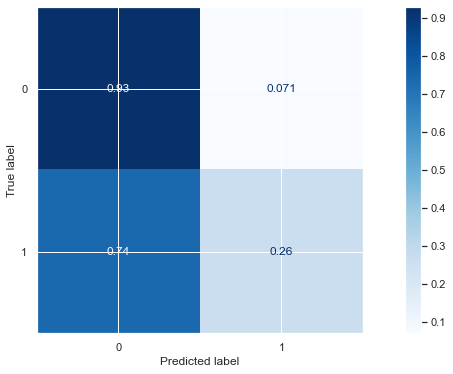

---------------------Train & Test scores : Log reg model with 11 PCA features-------------------
Train - Accuracy:  0.7663
Test - Accuracy:  0.7701
Train - Area under ROC score: 0.813 
Test - Area under ROC score: 0.8129 

              precision    recall  f1-score   support

           0       0.77      0.92      0.83     22691
           1       0.78      0.52      0.62     13126

    accuracy                           0.77     35817
   macro avg       0.77      0.72      0.73     35817
weighted avg       0.77      0.77      0.76     35817



<Figure size 648x648 with 0 Axes>

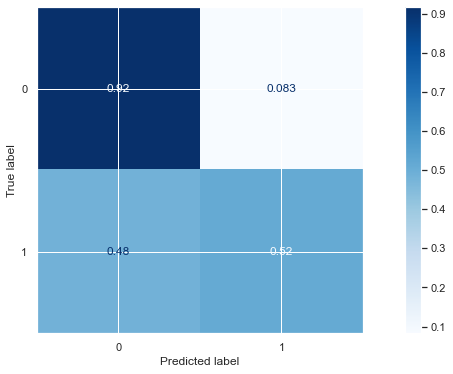

---------------------Train & Test scores : Log reg model with 22 PCA features-------------------
Train - Accuracy:  0.7946
Test - Accuracy:  0.7972
Train - Area under ROC score: 0.8413 
Test - Area under ROC score: 0.8419 

              precision    recall  f1-score   support

           0       0.80      0.92      0.85     22691
           1       0.80      0.59      0.68     13126

    accuracy                           0.80     35817
   macro avg       0.80      0.75      0.77     35817
weighted avg       0.80      0.80      0.79     35817



<Figure size 648x648 with 0 Axes>

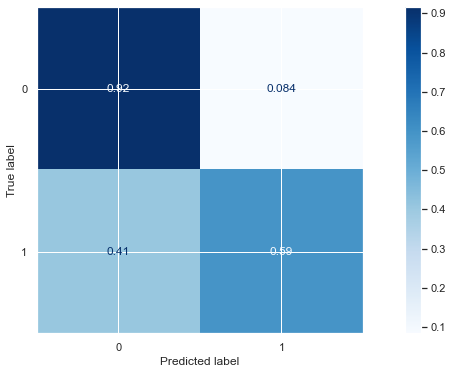

---------------------Train & Test scores : Log reg model with 37 PCA features-------------------
Train - Accuracy:  0.8092
Test - Accuracy:  0.8097
Train - Area under ROC score: 0.8658 
Test - Area under ROC score: 0.8667 

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     22691
           1       0.79      0.65      0.71     13126

    accuracy                           0.81     35817
   macro avg       0.81      0.78      0.79     35817
weighted avg       0.81      0.81      0.80     35817



<Figure size 648x648 with 0 Axes>

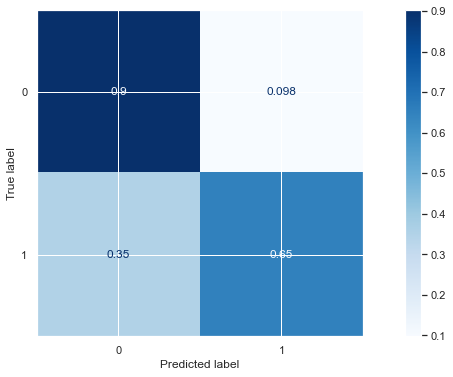

---------------------Train & Test scores : Log reg model with 50 PCA features-------------------
Train - Accuracy:  0.8209
Test - Accuracy:  0.8224
Train - Area under ROC score: 0.8742 
Test - Area under ROC score: 0.8747 

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.83      0.65      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

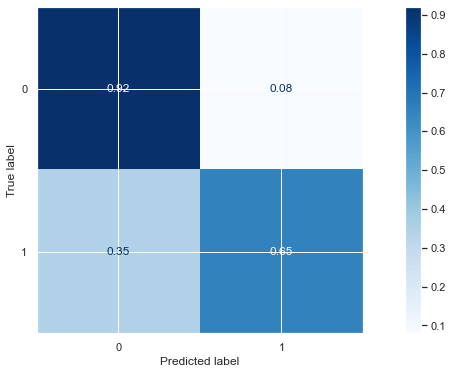

In [19]:
pca_feat = [5,11,22,37,50]
for i in pca_feat:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    X_train_i = pca.transform(X_train)
    X_test_i = pca.transform(X_test)

    logreg_model = LogisticRegression(max_iter=10000)
    logreg_model.fit(X_train_i, y_train)
    
    y_tr_pred = logreg_model.predict(X_train_i)
    y_tr_pred_prob = logreg_model.predict_proba(X_train_i)[:,1]
    
    y_pred = logreg_model.predict(X_test_i)
    y_pred_prob = logreg_model.predict_proba(X_test_i)[:,1]
    
    
    print('---------------------Train & Test scores : Log reg model with {} PCA features-------------------'.format(i))
    print('Train - Accuracy: ', round(accuracy_score(y_train,y_tr_pred),4))
    print('Test - Accuracy: ', round(accuracy_score(y_test,y_pred),4))
    print('Train - Area under ROC score: {} '.format(round(roc_auc_score(y_train, y_tr_pred_prob),4)))        
    print('Test - Area under ROC score: {} \n'.format(round(roc_auc_score(y_test, y_pred_prob),4)))
    print(classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(logreg_model, X_test_i, y_test, normalize='true', cmap = 'Blues')
    plt.show()
    

As we can see the higher the number of PCA features the higher our scores are.

But there is no improvement in the accuracy of our model so for our further modeling we will keep our data **without the PCA transformation**.

### 3.3 Logistic regression with GridSearch and RandomizedSearch CV

We will continue with hyperparameter tunning for our model.

We will use 2 methods to go through our parameters: the **GridSearchCV** and **RandomizedSearchCV**.

It is known that the randomized method is able to perform almost as well as the grid search, and considering that we are working with a rather large dataset that can cause high processing times, it is likely that the RandomizedSearchCV will be preffered, but for now we will just compare how well the 2 methods perform.

**GridSearchCV**

In [20]:
c_space = np.logspace(-4, 2, 10)
param_grid = {'C': c_space}

logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

print('Logistic Regression(with GridSearch CV) Parameters: ', logreg_cv.best_params_)
print('Logistic Regression(with GridSearch CV) best score: ', logreg_cv.best_score_)

print('\n')

Logistic Regression(with GridSearch CV) Parameters:  {'C': 100.0}
Logistic Regression(with GridSearch CV) best score:  0.8206577013772659




Train - Accuracy: 0.8212
Test - Accuracy: 0.8222
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

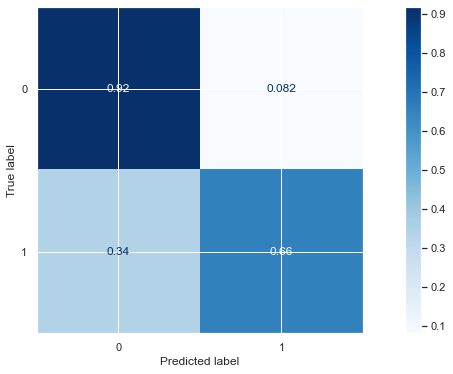

In [21]:
evaluation_block(logreg_cv)

Train - Area under ROC score: 0.8762
Test - Area under ROC score: 0.8766


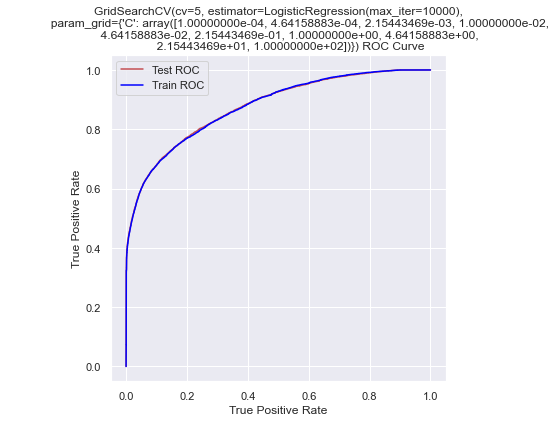

In [22]:
plot_ROC(logreg_cv)

In [23]:
save_scores(logreg_cv)

**RandomizedSearchCV**

In [24]:
params_dist = dict(C=uniform(loc=0, scale=5))

logreg_r_cv = RandomizedSearchCV(logreg, params_dist)
logreg_r_cv.fit(X_train, y_train)
y_pred = logreg_r_cv.predict(X_test)

print('Logistic Regression(with Randomized CV) Parameters: ', logreg_r_cv.best_params_)
print('Logistic Regression(with Randomized CV) best score: ', logreg_r_cv.best_score_)

print('\n')

Logistic Regression(with Randomized CV) Parameters:  {'C': 2.122856394872624}
Logistic Regression(with Randomized CV) best score:  0.8205500100921876




Train - Accuracy: 0.8211
Test - Accuracy: 0.8221
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

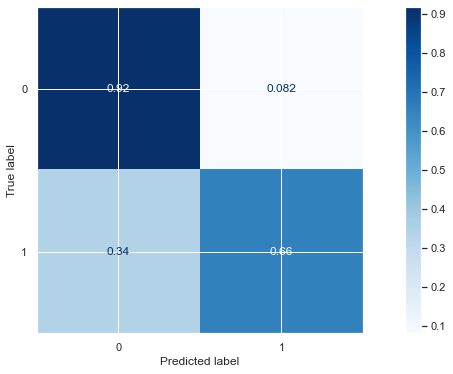

In [25]:
evaluation_block(logreg_r_cv)

Train - Area under ROC score: 0.8761
Test - Area under ROC score: 0.8765


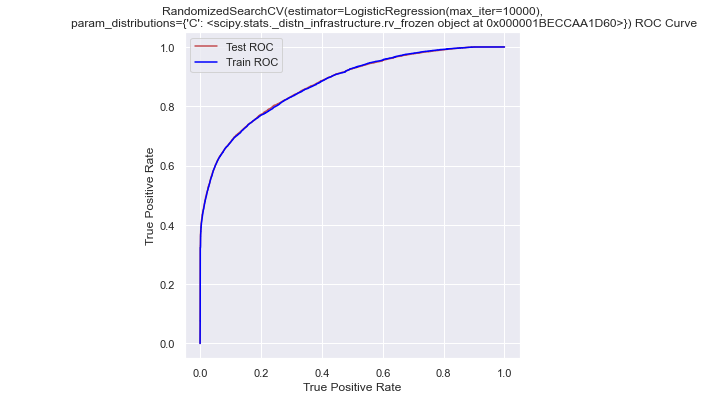

In [26]:
plot_ROC(logreg_r_cv)

In [27]:
save_scores(logreg_r_cv)

The observed **ROC_AUC** and **Accuracy** scores are no significantly different from the ones observed with the out of the box model.

### 3.3 Logistic regression with Ridge regularization

Furthermore, we will use the 2 types of regularizations: **Ridge** and **Lasso** on or Logistic Regression clasifier.
for each of these we will use 5 different alpha values.

--------------Train & Test scores : Ridge model with Alpha = 0.01 ---------------
Train - Accuracy: 0.8198
Test - Accuracy: 0.8216
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.65      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

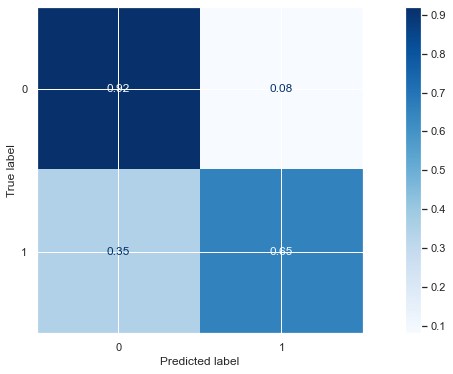

Train - Area under ROC score: 0.8748
Test - Area under ROC score: 0.8752


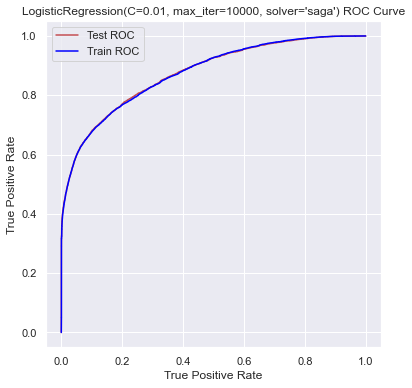

--------------Train & Test scores : Ridge model with Alpha = 0.31622776601683794 ---------------
Train - Accuracy: 0.8208
Test - Accuracy: 0.8225
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

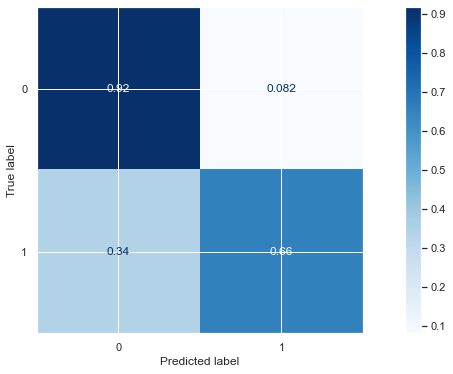

Train - Area under ROC score: 0.876
Test - Area under ROC score: 0.8763


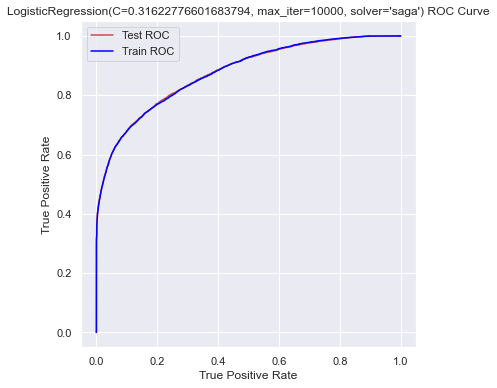

--------------Train & Test scores : Ridge model with Alpha = 10.0 ---------------
Train - Accuracy: 0.821
Test - Accuracy: 0.8221
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

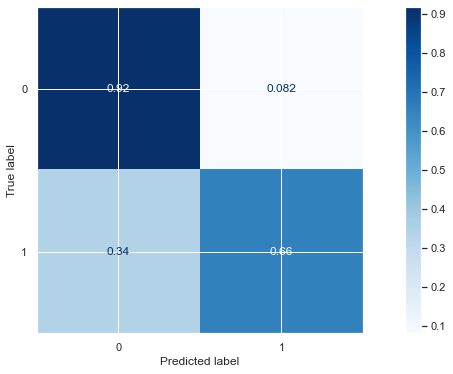

Train - Area under ROC score: 0.8761
Test - Area under ROC score: 0.8765


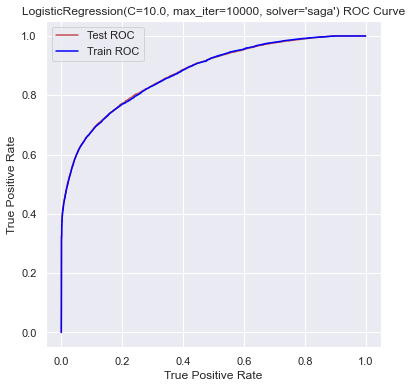

In [28]:
alpha_space = np.logspace(-2, 1, 3)

for a in alpha_space:
    print('--------------Train & Test scores : Ridge model with Alpha = {} ---------------'.format(a))

    ridge = LogisticRegression(C = a, penalty='l2', solver='saga', max_iter=10000)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    evaluation_block(ridge)
    plot_ROC(ridge)
    save_scores(ridge)

--------------Train & Test scores : Lasso model with Alpha = 0.01 ---------------
Train - Accuracy: 0.8206
Test - Accuracy: 0.8223
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.83      0.65      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

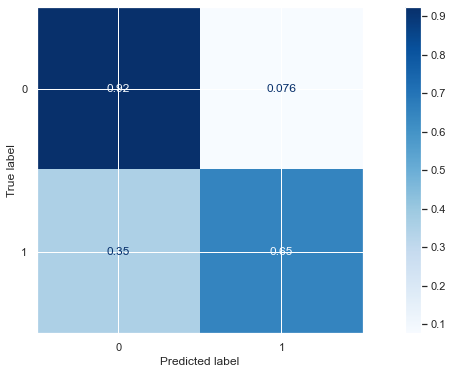

Train - Area under ROC score: 0.8741
Test - Area under ROC score: 0.8745


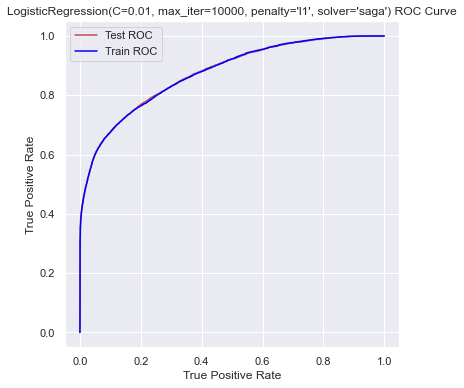

--------------Train & Test scores : Lasso model with Alpha = 0.31622776601683794 ---------------
Train - Accuracy: 0.8206
Test - Accuracy: 0.8222
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

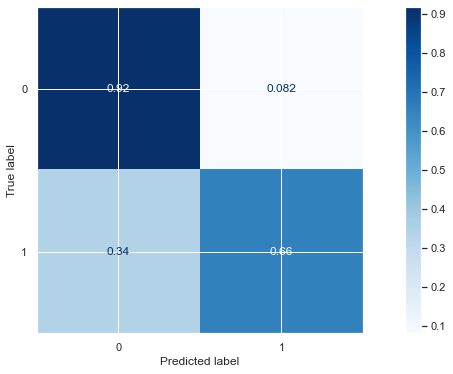

Train - Area under ROC score: 0.876
Test - Area under ROC score: 0.8764


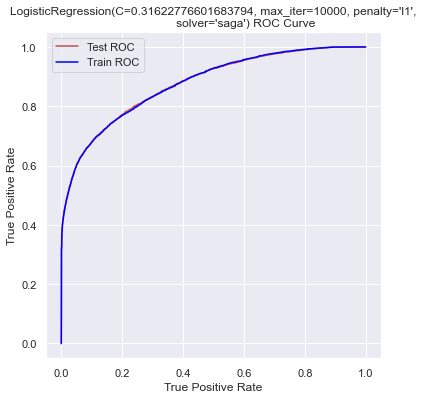

--------------Train & Test scores : Lasso model with Alpha = 10.0 ---------------
Train - Accuracy: 0.821
Test - Accuracy: 0.8221
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 648x648 with 0 Axes>

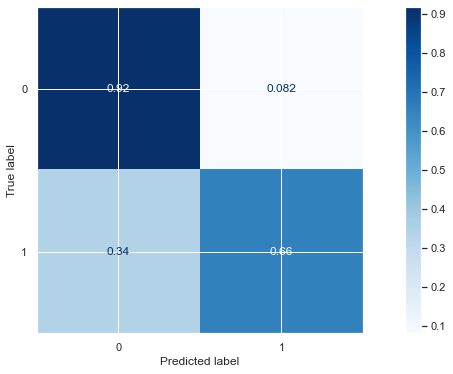

Train - Area under ROC score: 0.8761
Test - Area under ROC score: 0.8765


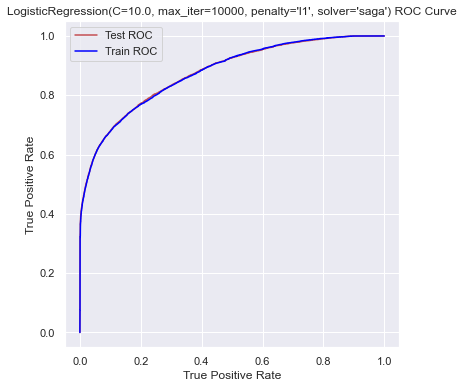

In [29]:
alpha_space = np.logspace(-2, 1, 3)

for a in alpha_space:

    lasso = LogisticRegression(C = a, penalty='l1', solver='saga', max_iter=10000)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    print('--------------Train & Test scores : Lasso model with Alpha = {} ---------------'.format(a))
    evaluation_block(lasso)
    plot_ROC(lasso)
    save_scores(lasso)

> Even after using both types of regularizations on our LogisticRegression model, with cross validations on multiple alphas, the model's scores remain relatively constant, without improving the model performance significantly.


In [30]:
results.sort_values('test_accuracy', ascending = False)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
4,"LogisticRegression(C=0.31622776601683794, max_iter=10000, solver='saga')",0.8208,0.8225,0.8760,0.8763
0,LogisticRegression(max_iter=10000),0.8211,0.8224,0.8761,0.8765
6,"LogisticRegression(C=0.01, max_iter=10000, penalty='l1', solver='saga')",0.8206,0.8223,0.8741,0.8745
1,"GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),\n param_grid={'C': ...",0.8212,0.8222,0.8762,0.8766
7,"LogisticRegression(C=0.31622776601683794, max_iter=10000, penalty='l1',\n solv...",0.8206,0.8222,0.8760,0.8764
2,"RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000),\n param_distr...",0.8211,0.8221,0.8761,0.8765
5,"LogisticRegression(C=10.0, max_iter=10000, solver='saga')",0.8210,0.8221,0.8761,0.8765
8,"LogisticRegression(C=10.0, max_iter=10000, penalty='l1', solver='saga')",0.8210,0.8221,0.8761,0.8765
3,"LogisticRegression(C=0.01, max_iter=10000, solver='saga')",0.8198,0.8216,0.8748,0.8752



> We will continue our classifiers models eploration with **KNeighborsClassifier**.

### 4. KNN classifier

We will use a KNeighborsClassifier with a variation of **n_neighbors** parameters.

---------------Test scores : KNeighborsClassifier model with 2 neighbors--------------
Test - Accuracy:  0.8288
Test - Area under ROC score: 0.8512 

1627.296875 seconds
---------------Test scores : KNeighborsClassifier model with 3 neighbors--------------
Test - Accuracy:  0.8236
Test - Area under ROC score: 0.8699 

1766.5625 seconds
---------------Test scores : KNeighborsClassifier model with 6 neighbors--------------
Test - Accuracy:  0.8284
Test - Area under ROC score: 0.8849 

1869.640625 seconds
---------------Test scores : KNeighborsClassifier model with 7 neighbors--------------
Test - Accuracy:  0.8266
Test - Area under ROC score: 0.8875 

1891.40625 seconds
---------------Test scores : KNeighborsClassifier model with 10 neighbors--------------
Test - Accuracy:  0.829
Test - Area under ROC score: 0.8905 

1884.953125 seconds
---------------Test scores : KNeighborsClassifier model with 11 neighbors--------------
Test - Accuracy:  0.8275
Test - Area under ROC score: 0.8909 

19

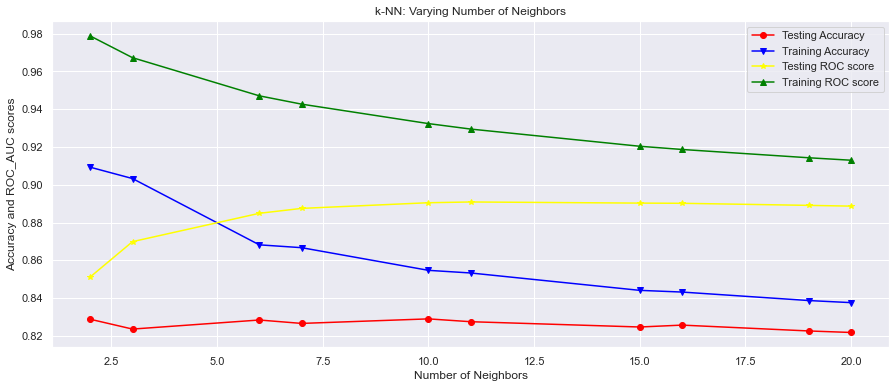

In [31]:
no_neighbors = (2,3,6,7,10,11,15,16,19,20)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))
train_ROC = np.empty(len(no_neighbors))
test_ROC = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    start = time.process_time()  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    
    y_pred = knn.predict(X_test)
    y_pred_prob = knn.predict_proba(X_test)[:,1]
    
    y_tr_pred = knn.predict(X_train)
    y_tr_pred_prob = knn.predict_proba(X_train)[:,1]
    

    train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
    test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    
    train_accuracy[i] = train_acc
    test_accuracy[i] = test_acc
    train_ROC[i] = train_roc_score
    test_ROC[i] = test_roc_score
    
    save_scores(knn)
    
    print('---------------Test scores : KNeighborsClassifier model with {} neighbors--------------'.format(k))
    print('Test - Accuracy: ', round(accuracy_score(y_test,y_pred),4))    
    print('Test - Area under ROC score: {} \n'.format(round(roc_auc_score(y_test, y_pred_prob),4)))
    
    print(time.process_time() - start, 'seconds')

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy', marker = 'o', c = 'red')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy', marker = 'v', c = 'blue')
plt.plot(no_neighbors, test_ROC, label = 'Testing ROC score', marker = '*', c = 'yellow')
plt.plot(no_neighbors, train_ROC, label = 'Training ROC score', marker = '^', c = 'green')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy and ROC_AUC scores')
plt.show()

We can also see
The optimal KNeighborsClassifier model is the model with **n_neighbors = 10** because:
* it has the highest test score.
* is the number of n_neighbors where the roc_auc score begins to become constant.


The main issue with this model is that it can take around 30 minutes for it to fit to data and predict, considerably more than any other models used so far.

We'll run again the best KNN model found, plot the confusion matrix and the ROC curves.

In [32]:
results.sort_values('test_accuracy', ascending = False)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
13,KNeighborsClassifier(n_neighbors=10),0.8547,0.8290,0.9324,0.8905
9,KNeighborsClassifier(n_neighbors=2),0.9093,0.8288,0.9788,0.8512
11,KNeighborsClassifier(n_neighbors=6),0.8682,0.8284,0.9471,0.8849
14,KNeighborsClassifier(n_neighbors=11),0.8533,0.8275,0.9295,0.8909
12,KNeighborsClassifier(n_neighbors=7),0.8667,0.8266,0.9427,0.8875
16,KNeighborsClassifier(n_neighbors=16),0.8432,0.8257,0.9187,0.8902
15,KNeighborsClassifier(n_neighbors=15),0.8441,0.8247,0.9204,0.8903
10,KNeighborsClassifier(n_neighbors=3),0.9033,0.8236,0.9673,0.8699
17,KNeighborsClassifier(n_neighbors=19),0.8387,0.8226,0.9143,0.8891
4,"LogisticRegression(C=0.31622776601683794, max_iter=10000, solver='saga')",0.8208,0.8225,0.8760,0.8763


All our KNN models performed better than the LogisticRegression.

## 5. Random Forest Classifier

Moving forward we will use two Ensemble Classifiers.

We will first try Random Forest Classifier. This will improve the usability of the model because of it's ability to handle non-linear features and outliers. The data we use will not have to be binned or scaled, making it useful for raw data to be used for direct model predictions.

One major concearn with Random Forest Classifiers is that it is prone to overfitting, so we will do feature importance visualization with sci-kit learn's **permutation_importance** as well as **feature_importances_**. 

In order to prioritize predictability power over small metric improvements(thus decreasing model's **bias** on training data) we will then do a feature selection using the metrics for both Training Set and Test Set.

### 5.1 Out of the box Random Forest Classifier

In [33]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Train - Accuracy: 0.9922
Test - Accuracy: 0.8724
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.82     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 648x648 with 0 Axes>

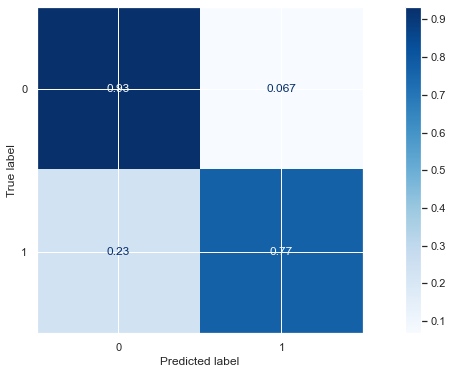

In [34]:
evaluation_block(rfc)

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9371


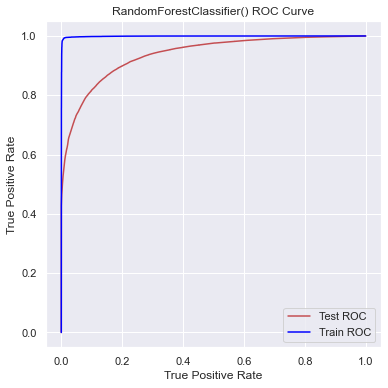

In [35]:
plot_ROC(rfc)

In [36]:
save_scores(rfc)

We observe the big increase in scoring metrics from the KNN and LogisticRegression clasifiers used previously.

We can notice as well that the out of the box **model is overfitted on our training data**, having extremely high accuracy and roc_auc scores.

In this regard we will first determine the importances of the features in our model and then select just the most important. 

Then to further optimizdo hyperparameter tunning on this model.

### 5.2 Hyperparameter tunning with RFC

---------Train & Test scores : RFC model with n_estimators = 50 and max_depth = 10 ---------
Train - Accuracy: 0.8249
Test - Accuracy: 0.8237
Validation - Classification report
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     22691
           1       0.90      0.58      0.71     13126

    accuracy                           0.82     35817
   macro avg       0.85      0.77      0.79     35817
weighted avg       0.84      0.82      0.81     35817



<Figure size 648x648 with 0 Axes>

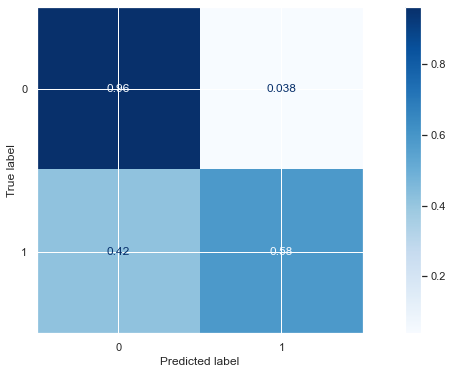

Train - Area under ROC score: 0.9064
Test - Area under ROC score: 0.899


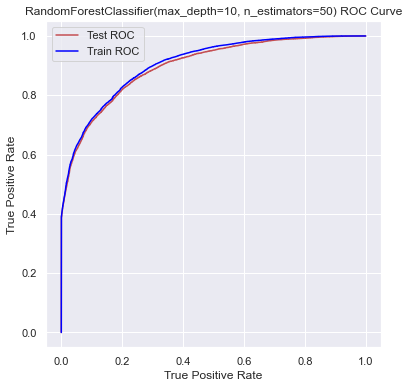

---------Train & Test scores : RFC model with n_estimators = 100 and max_depth = 10 ---------
Train - Accuracy: 0.8264
Test - Accuracy: 0.8245
Validation - Classification report
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     22691
           1       0.90      0.59      0.71     13126

    accuracy                           0.82     35817
   macro avg       0.85      0.77      0.79     35817
weighted avg       0.84      0.82      0.81     35817



<Figure size 648x648 with 0 Axes>

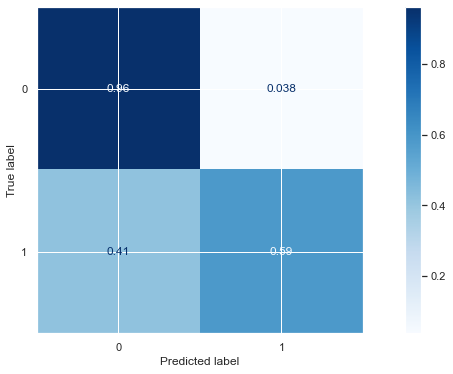

Train - Area under ROC score: 0.9093
Test - Area under ROC score: 0.9015


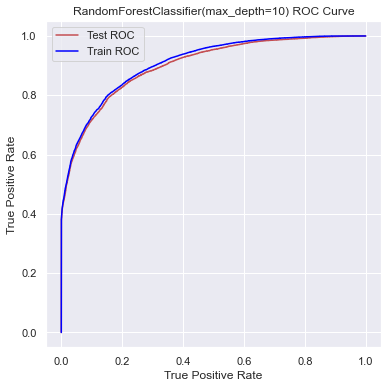

---------Train & Test scores : RFC model with n_estimators = 200 and max_depth = 10 ---------
Train - Accuracy: 0.8257
Test - Accuracy: 0.8246
Validation - Classification report
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     22691
           1       0.90      0.59      0.71     13126

    accuracy                           0.82     35817
   macro avg       0.85      0.77      0.79     35817
weighted avg       0.84      0.82      0.81     35817



<Figure size 648x648 with 0 Axes>

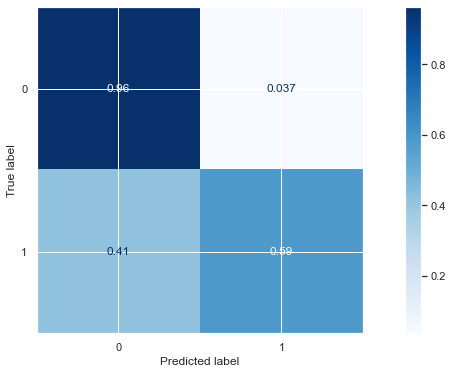

Train - Area under ROC score: 0.9092
Test - Area under ROC score: 0.9016


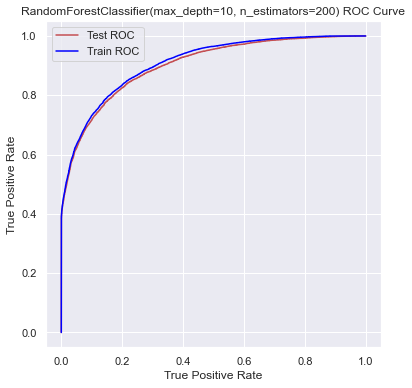

---------Train & Test scores : RFC model with n_estimators = 50 and max_depth = 20 ---------
Train - Accuracy: 0.9045
Test - Accuracy: 0.8592
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     22691
           1       0.87      0.72      0.79     13126

    accuracy                           0.86     35817
   macro avg       0.86      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 648x648 with 0 Axes>

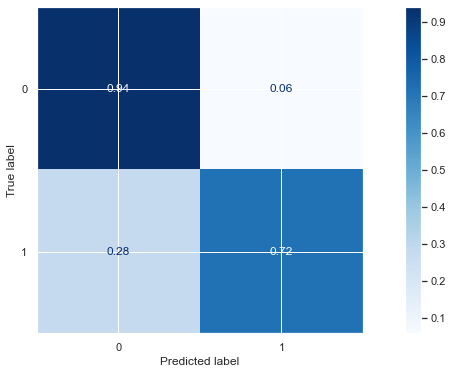

Train - Area under ROC score: 0.9767
Test - Area under ROC score: 0.93


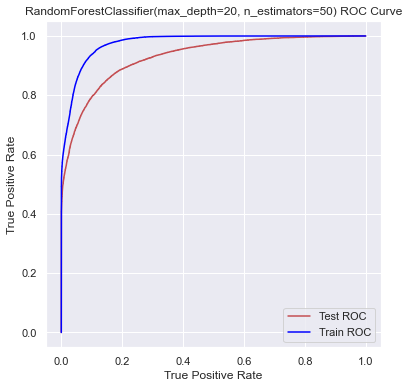

---------Train & Test scores : RFC model with n_estimators = 100 and max_depth = 20 ---------
Train - Accuracy: 0.9034
Test - Accuracy: 0.8598
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     22691
           1       0.88      0.72      0.79     13126

    accuracy                           0.86     35817
   macro avg       0.86      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 648x648 with 0 Axes>

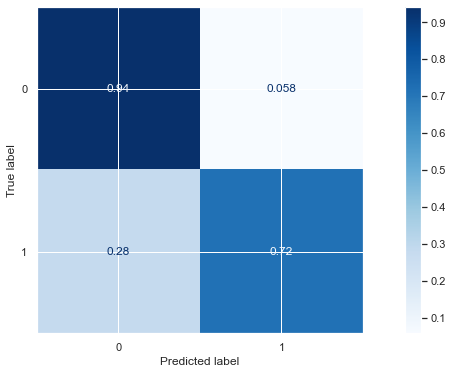

Train - Area under ROC score: 0.9764
Test - Area under ROC score: 0.9313


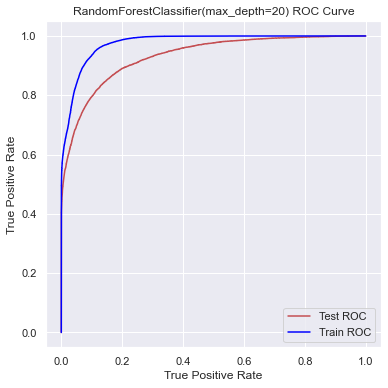

---------Train & Test scores : RFC model with n_estimators = 200 and max_depth = 20 ---------
Train - Accuracy: 0.9038
Test - Accuracy: 0.8604
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     22691
           1       0.88      0.72      0.79     13126

    accuracy                           0.86     35817
   macro avg       0.87      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 648x648 with 0 Axes>

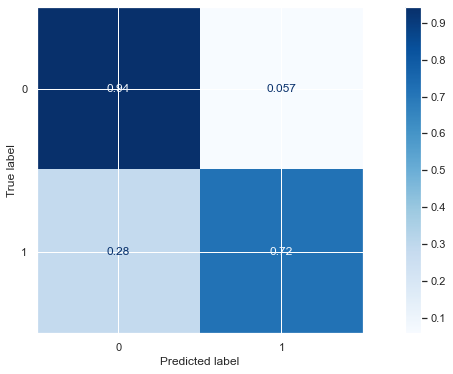

Train - Area under ROC score: 0.9771
Test - Area under ROC score: 0.9323


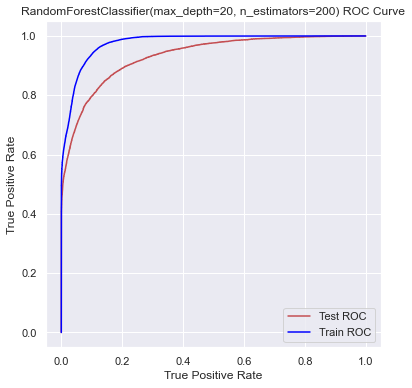

---------Train & Test scores : RFC model with n_estimators = 50 and max_depth = None ---------
Train - Accuracy: 0.992
Test - Accuracy: 0.8713
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.81     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 648x648 with 0 Axes>

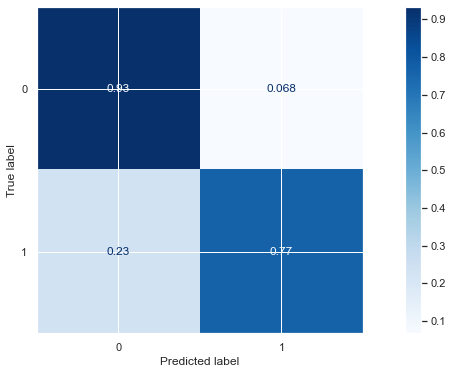

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9352


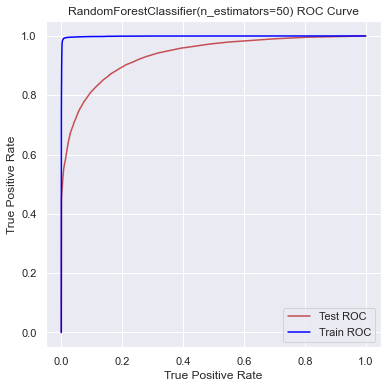

---------Train & Test scores : RFC model with n_estimators = 100 and max_depth = None ---------
Train - Accuracy: 0.9922
Test - Accuracy: 0.8718
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.81     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 648x648 with 0 Axes>

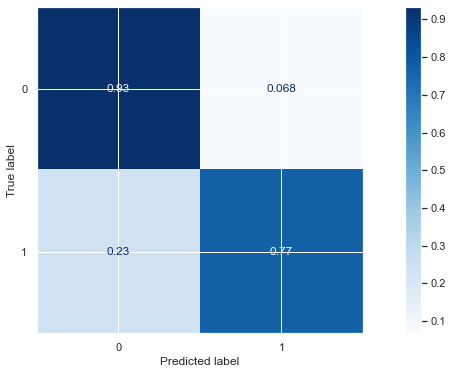

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9369


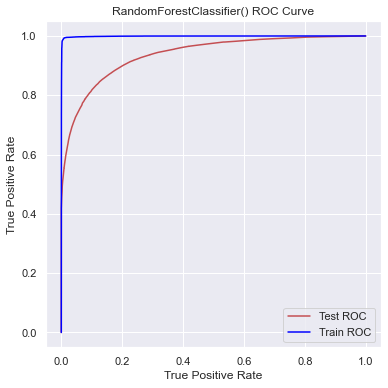

---------Train & Test scores : RFC model with n_estimators = 200 and max_depth = None ---------
Train - Accuracy: 0.9922
Test - Accuracy: 0.8726
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.82     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 648x648 with 0 Axes>

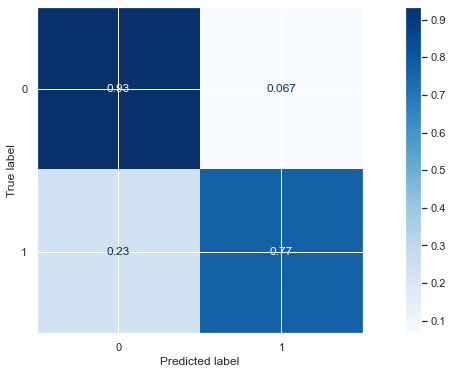

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9375


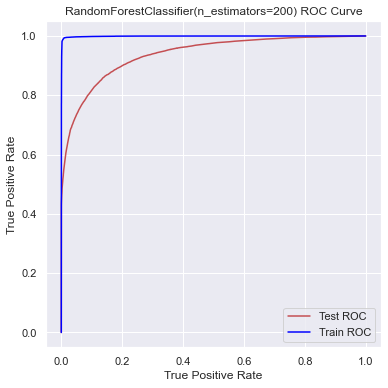

In [37]:
depth = [10, 20, None]
estimators = [50,100,200]

for d in depth:
    for e in estimators:
        print('---------Train & Test scores : RFC model with n_estimators = {} and max_depth = {} ---------'.format(e, d))
        rfc_i = RandomForestClassifier(n_estimators = e, max_depth = d)
        rfc_i.fit(X_train, y_train)
        y_pred = rfc_i.predict(X_test)
        evaluation_block(rfc_i)
        plot_ROC(rfc_i)
        save_scores(rfc_i)

> Let's check our results DataFrame

In [38]:
results.sort_values('test_accuracy', ascending = False)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
28,"(DecisionTreeClassifier(max_features='auto', random_state=1233902736), DecisionTreeClassifier(ma...",0.9922,0.8726,0.9991,0.9375
19,"(DecisionTreeClassifier(max_features='auto', random_state=259966552), DecisionTreeClassifier(max...",0.9922,0.8724,0.9991,0.9371
27,"(DecisionTreeClassifier(max_features='auto', random_state=64402675), DecisionTreeClassifier(max_...",0.9922,0.8718,0.9991,0.9369
26,"(DecisionTreeClassifier(max_features='auto', random_state=1646429223), DecisionTreeClassifier(ma...",0.9920,0.8713,0.9991,0.9352
25,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9038,0.8604,0.9771,0.9323
24,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9034,0.8598,0.9764,0.9313
23,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9045,0.8592,0.9767,0.9300
13,KNeighborsClassifier(n_neighbors=10),0.8547,0.8290,0.9324,0.8905
9,KNeighborsClassifier(n_neighbors=2),0.9093,0.8288,0.9788,0.8512
11,KNeighborsClassifier(n_neighbors=6),0.8682,0.8284,0.9471,0.8849


**We can see a generalized trend in our scoring, with DecisionTreeClassifier being the best model, folowed by KNN and lastly by LogisticRegression.**

>Before moving to CatBoost, the last model that we will try in this notebook, we will choose the best model so far and we will furter improve its predictive power while lowering the Bias to training data by doing feature selection on our Train set.

We will use 2 variations of DecisionTreeClassifier for our feature selection:
* **Highest score -  DecisionTreeClassifier - model with n_estimators = 200 and max_depth = None**
   * Train - Accuracy: 0.9922
   * Test - Accuracy: 0.8726
   * Train - Area under ROC score: 0.9991
   * Test - Area under ROC score: 0.9375
* **4th highest score - DecisionTreeClassifier - model with n_estimators = 200 and max_depth = 20**
   * Train - Accuracy: 0.9038
   * Test - Accuracy: 0.8604
   * Train - Area under ROC score: 0.9771
   * Test - Area under ROC score: 0.9323

In [39]:
rfc1 = RandomForestClassifier(n_estimators = 200)
rfc4 = RandomForestClassifier(n_estimators = 200, max_depth = 20)

### 5.3 Feature selection using permutation_importance and feature_importances_

Let's have a look at the most important features in our model.

In [40]:
result = permutation_importance(rfc, X_test, y_test, n_repeats=10)
perm_sorted_idx = result.importances_mean.argsort()

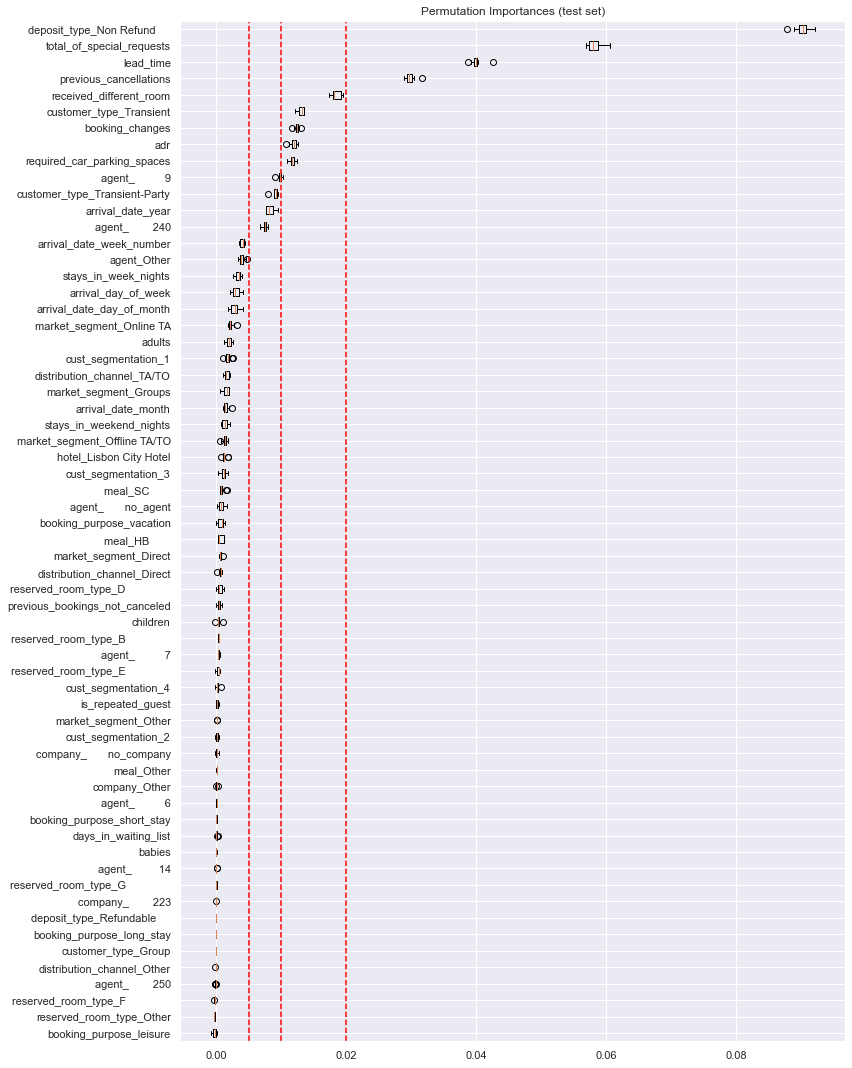

In [41]:
fig, ax = plt.subplots(figsize=(12, 15))

ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X_dumm.columns[perm_sorted_idx])
[plt.axvline(x=i, linestyle='--', c = 'red') for i in [.005,.01,.02]]
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

We have some different thresholds on which we could select our top features based on the features permutation test:
* 0.02 - top 4 features
* 0.01 - top 9 features
* 0.005 - top 13 features

In [42]:
# Choosing most important top 4,9,and 13 features.
top4_perm = X_dumm.columns[perm_sorted_idx][-4:]
top9_perm = X_dumm.columns[perm_sorted_idx][-9:]
top13_perm = X_dumm.columns[perm_sorted_idx][-13:]
top4_perm, top9_perm, top13_perm

(Index(['previous_cancellations', 'lead_time', 'total_of_special_requests',
        'deposit_type_Non Refund     '],
       dtype='object'),
 Index(['required_car_parking_spaces', 'adr', 'booking_changes',
        'customer_type_Transient', 'received_different_room',
        'previous_cancellations', 'lead_time', 'total_of_special_requests',
        'deposit_type_Non Refund     '],
       dtype='object'),
 Index(['agent_        240', 'arrival_date_year',
        'customer_type_Transient-Party', 'agent_          9',
        'required_car_parking_spaces', 'adr', 'booking_changes',
        'customer_type_Transient', 'received_different_room',
        'previous_cancellations', 'lead_time', 'total_of_special_requests',
        'deposit_type_Non Refund     '],
       dtype='object'))

A secondary method to see how the features impacted the model is using **feature_importances_**.Plotting the feature importances is a way that you can gain a perspective on which features are driving the model predictions.

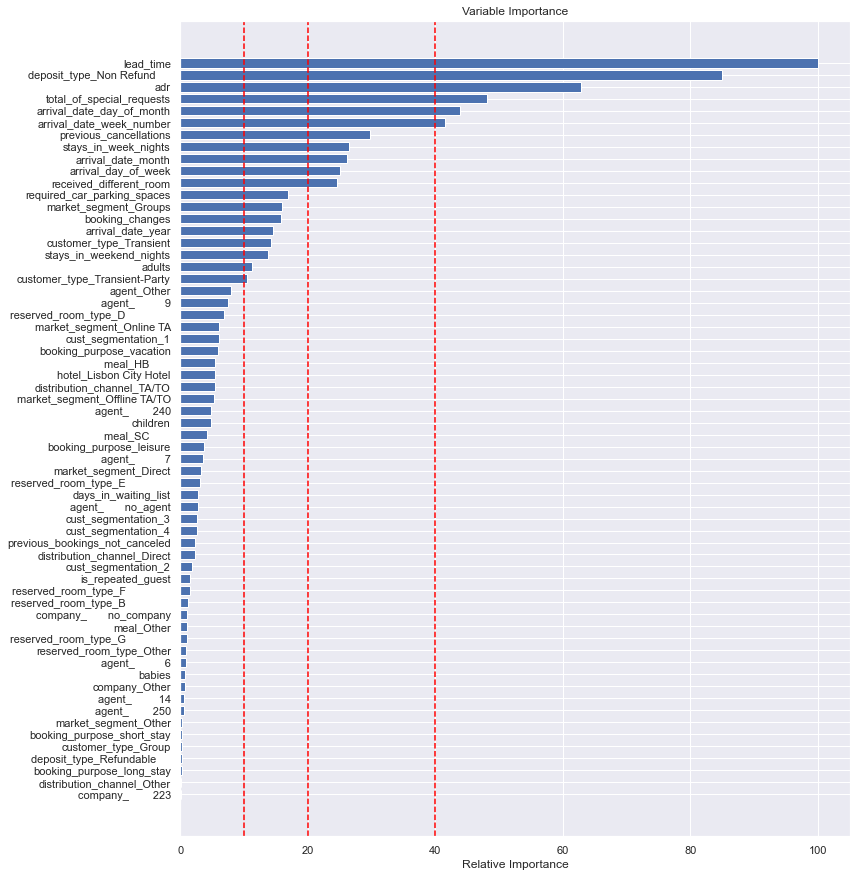

In [43]:
feature_importance = rfc.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
feat_sorted_idx = np.argsort(feature_importance)

pos = np.arange(feat_sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,15))
plt.barh(pos, feature_importance[feat_sorted_idx], align='center')
[plt.axvline(x=i, linestyle='--', c = 'red') for i in [10,20,40]]
plt.yticks(pos, X_dumm.columns[feat_sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

We have some different thresholds on which we could select our top features:
* 10% - top 19 features
* 20% - top 11 features
* 40% - top 6 features

In [44]:
# Choosing most important top 4,9,and 13 features.
top6_feat = X_dumm.columns[feat_sorted_idx][-6:]
top11_feat = X_dumm.columns[feat_sorted_idx][-11:]
top19_feat = X_dumm.columns[feat_sorted_idx][-19:]
top6_feat, top11_feat, top19_feat

(Index(['arrival_date_week_number', 'arrival_date_day_of_month',
        'total_of_special_requests', 'adr', 'deposit_type_Non Refund     ',
        'lead_time'],
       dtype='object'),
 Index(['received_different_room', 'arrival_day_of_week', 'arrival_date_month',
        'stays_in_week_nights', 'previous_cancellations',
        'arrival_date_week_number', 'arrival_date_day_of_month',
        'total_of_special_requests', 'adr', 'deposit_type_Non Refund     ',
        'lead_time'],
       dtype='object'),
 Index(['customer_type_Transient-Party', 'adults', 'stays_in_weekend_nights',
        'customer_type_Transient', 'arrival_date_year', 'booking_changes',
        'market_segment_Groups', 'required_car_parking_spaces',
        'received_different_room', 'arrival_day_of_week', 'arrival_date_month',
        'stays_in_week_nights', 'previous_cancellations',
        'arrival_date_week_number', 'arrival_date_day_of_month',
        'total_of_special_requests', 'adr', 'deposit_type_Non Refund

Using the 2 methods combined we can choose the folowing features for our RandomForestClassifier model:
* least_feat
* mid_feat
* most_feat

In [45]:
least_feat = set().union(top6_feat, top4_perm)
mid_feat = set().union(top11_feat, top9_perm)
most_feat = set().union(top19_feat, top13_perm)

len(least_feat), len(mid_feat), len(most_feat)

(7, 14, 21)

### 5.4 Fitting best models on features subset

----------Random forest model on train set with 7 most important features-------
RandomForestClassifier(n_estimators=200)
Train - Accuracy: 0.9867
Test - Accuracy: 0.8271
Validation - Classification report
               precision    recall  f1-score   support

           0       0.83      0.91      0.87     22478
           1       0.82      0.68      0.75     13339

    accuracy                           0.83     35817
   macro avg       0.83      0.80      0.81     35817
weighted avg       0.83      0.83      0.82     35817



<Figure size 648x648 with 0 Axes>

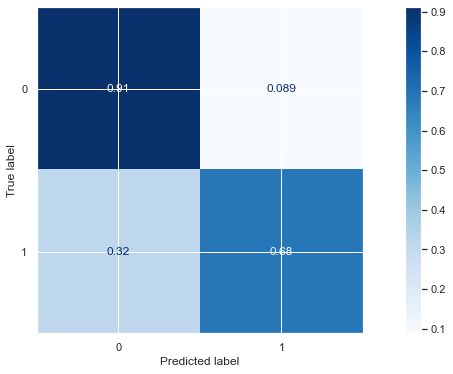

Train - Area under ROC score: 0.9981
Test - Area under ROC score: 0.8925


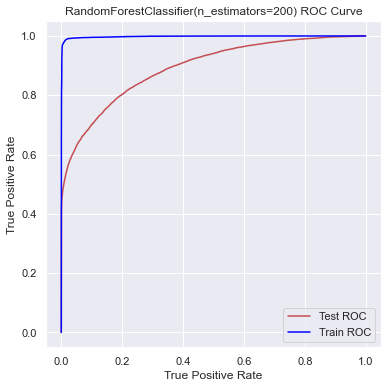

RandomForestClassifier(max_depth=20, n_estimators=200)
Train - Accuracy: 0.9341
Test - Accuracy: 0.8257
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.93      0.87     22478
           1       0.85      0.65      0.73     13339

    accuracy                           0.83     35817
   macro avg       0.83      0.79      0.80     35817
weighted avg       0.83      0.83      0.82     35817



<Figure size 648x648 with 0 Axes>

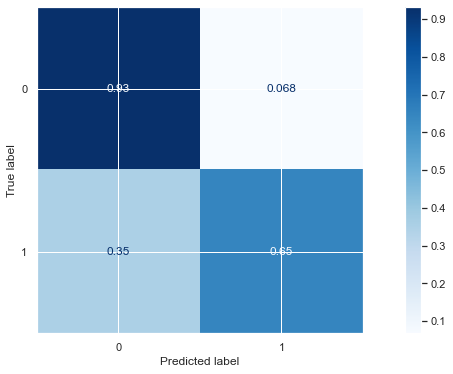

Train - Area under ROC score: 0.9886
Test - Area under ROC score: 0.8898


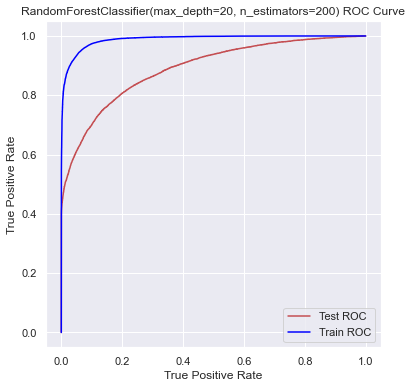

----------Random forest model on train set with 14 most important features-------
RandomForestClassifier(n_estimators=200)
Train - Accuracy: 0.9909
Test - Accuracy: 0.8509
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     22595
           1       0.84      0.74      0.78     13222

    accuracy                           0.85     35817
   macro avg       0.85      0.83      0.84     35817
weighted avg       0.85      0.85      0.85     35817



<Figure size 648x648 with 0 Axes>

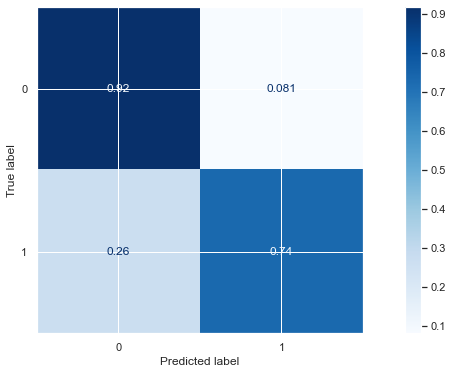

Train - Area under ROC score: 0.9988
Test - Area under ROC score: 0.9216


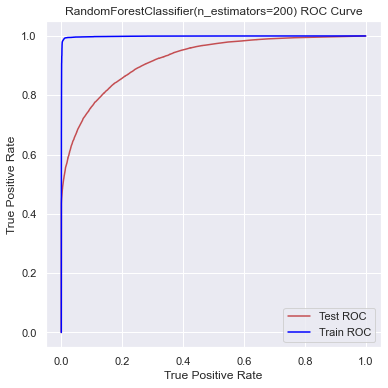

RandomForestClassifier(max_depth=20, n_estimators=200)
Train - Accuracy: 0.9183
Test - Accuracy: 0.8438
Validation - Classification report
               precision    recall  f1-score   support

           0       0.84      0.93      0.88     22595
           1       0.85      0.69      0.77     13222

    accuracy                           0.84     35817
   macro avg       0.85      0.81      0.82     35817
weighted avg       0.84      0.84      0.84     35817



<Figure size 648x648 with 0 Axes>

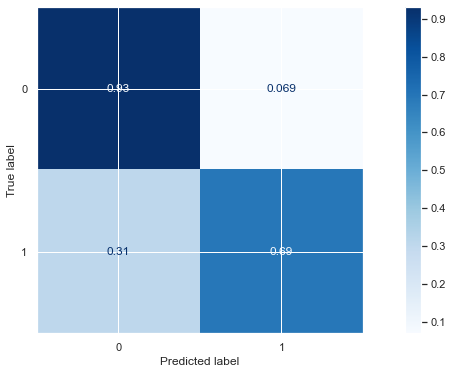

Train - Area under ROC score: 0.9836
Test - Area under ROC score: 0.9171


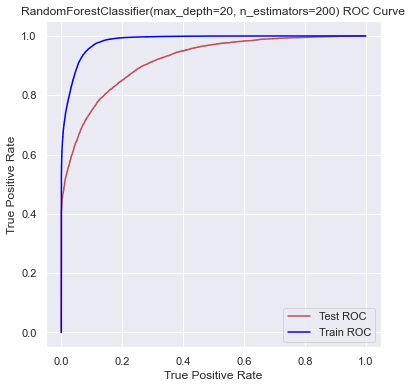

----------Random forest model on train set with 21 most important features-------
RandomForestClassifier(n_estimators=200)
Train - Accuracy: 0.9919
Test - Accuracy: 0.8693
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22531
           1       0.86      0.77      0.81     13286

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 648x648 with 0 Axes>

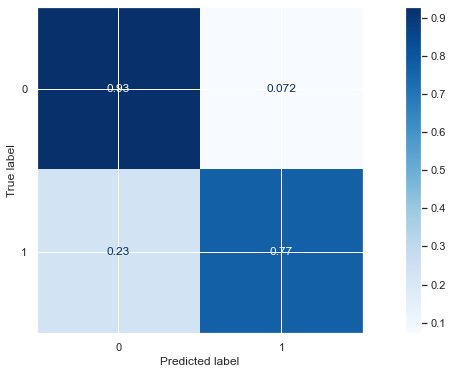

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9334


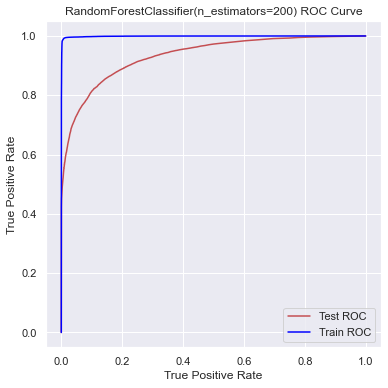

RandomForestClassifier(max_depth=20, n_estimators=200)
Train - Accuracy: 0.9251
Test - Accuracy: 0.861
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.94      0.89     22531
           1       0.87      0.74      0.80     13286

    accuracy                           0.86     35817
   macro avg       0.86      0.84      0.85     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 648x648 with 0 Axes>

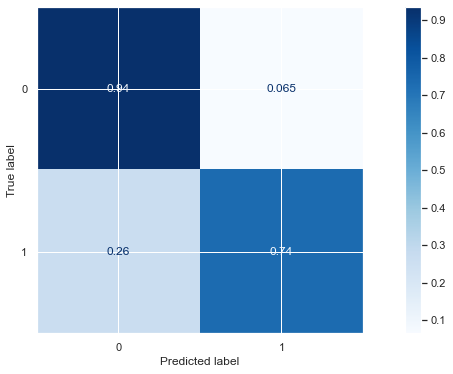

Train - Area under ROC score: 0.9853
Test - Area under ROC score: 0.9302


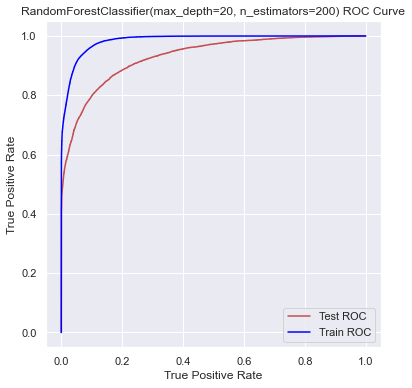

In [46]:
# ecause we need to alter the number of features in or X, X_train and X-test, we will create function 
# so that the modifications on this variables can happen localy, and outside the scope of this function
# the data to remain unchanged.


def selecting_features():
    for columns_set in [least_feat, mid_feat, most_feat]:
        X = X_dumm[columns_set]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        print('----------Random forest model on train set with {} most important features-------'.format(len(columns_set)))
        for rfc_model in [rfc1, rfc4]:
            print(rfc_model)
            rfc_model.fit(X_train, y_train)
            y_pred = rfc_model.predict(X_test)
            
            y_tr_pred = rfc_model.predict(X_train)
    
            train_acc = round(accuracy_score(y_train,y_tr_pred),4)
            test_acc = round(accuracy_score(y_test,y_pred),4)
    
            print("Train - Accuracy:", train_acc)
            print("Test - Accuracy:", test_acc)
            print('Validation - Classification report\n', classification_report(y_test,y_pred))
            plt.figure(figsize=(9,9))
            plot_confusion_matrix(rfc_model, X_test, y_test, normalize='true', cmap = 'Blues')
            plt.show()
            
            y_pred_prob = rfc_model.predict_proba(X_test)[:,1]
            y_tr_pred_prob = rfc_model.predict_proba(X_train)[:,1]
        
            train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
            test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)
        
            print('Train - Area under ROC score: {}'.format(train_roc_score))
            print('Test - Area under ROC score: {}'.format(test_roc_score))
        
            fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob)
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_tr_pred_prob)
            plt.figure(figsize=(6,6))
            plt.plot(fpr_test, tpr_test, label = 'Test ROC', c = 'r')
            plt.plot(fpr_train, tpr_train, label = 'Train ROC', c = 'blue')
            plt.xlabel('True Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.title('{} ROC Curve'.format(rfc_model))
            plt.show()
            
            new_row = {'model':rfc_model,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_ROC': train_roc_score,
               'test_ROC': test_roc_score}
            results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
            
selecting_features()

In [50]:
#let's check how the latest models(indexes 31 to 36) are compared to the rest in the top 15 scores
results.sort_values('test_accuracy', ascending = False).head(15)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
28,"(DecisionTreeClassifier(max_features='auto', random_state=1233902736), DecisionTreeClassifier(ma...",0.9922,0.8726,0.9991,0.9375
19,"(DecisionTreeClassifier(max_features='auto', random_state=259966552), DecisionTreeClassifier(max...",0.9922,0.8724,0.9991,0.9371
27,"(DecisionTreeClassifier(max_features='auto', random_state=64402675), DecisionTreeClassifier(max_...",0.9922,0.8718,0.9991,0.9369
26,"(DecisionTreeClassifier(max_features='auto', random_state=1646429223), DecisionTreeClassifier(ma...",0.9920,0.8713,0.9991,0.9352
33,"(DecisionTreeClassifier(max_features='auto', random_state=446869832), DecisionTreeClassifier(max...",0.9919,0.8693,0.9991,0.9334
34,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9251,0.8610,0.9853,0.9302
25,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9038,0.8604,0.9771,0.9323
24,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9034,0.8598,0.9764,0.9313
23,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9045,0.8592,0.9767,0.9300
31,"(DecisionTreeClassifier(max_features='auto', random_state=446869832), DecisionTreeClassifier(max...",0.9909,0.8509,0.9988,0.9216


The best model so far is the **DecisionTreeClassifier** with the folowing hyperparameters:
 - max_depth= None
 - n_estimators=200

## 6. Catboost

Before concluding our modeling we will have a quick look at how CatBoost will perform on our data.

The big advantage of this model over any model from **sklearn** is the fact that it is able to work on categorical data.

Other advantages are: it is faster than most other models, and generally it produces very high scores.

In [51]:
cat = CatBoostClassifier(custom_loss=[metrics.Accuracy()],logging_level='Silent')

In [52]:
categorical_features_indices = np.where(X.dtypes == np.object)[0]
categorical_features_indices

array([ 0, 11, 12, 13, 17, 19, 20, 21, 23, 28, 30], dtype=int64)

In [53]:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X, y, test_size = 0.3)
cat.fit(X_cat_train, y_cat_train, cat_features=categorical_features_indices, eval_set=(X_cat_test, y_cat_test),
        logging_level='Silent', plot=True)
cv_params = cat.get_params()
cv_params.update({'loss_function': metrics.Logloss()})
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), cv_params, plot=True)
    
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(np.max(cv_data['test-Accuracy-mean']),
cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],np.argmax(cv_data['test-Accuracy-mean'])))
    
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))
    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best validation accuracy score: 0.85±0.00 on step 980
Precise validation accuracy score: 0.8485371461157097


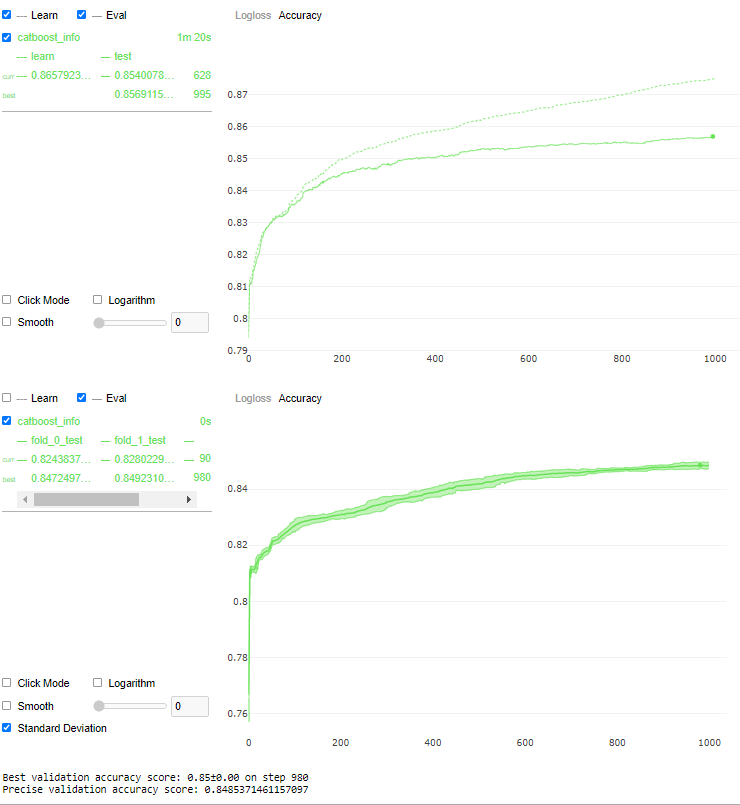

The Catboost model returned the folowing metrics:
* Best validation accuracy score: 0.85±0.00 on step 980
* Precise validation accuracy score: 0.8485371461157097

The scores are lower compared to the scores returned by our Random Forest Classifier but higher than KNN and Logistic regression.

In [57]:
# we'll manually append the test accuracy score    
new_row = {'model': 'Catboost model',
               'train_accuracy': np.nan,
               'test_accuracy': 0.8485,
               'train_ROC': np.nan,
               'test_ROC': np.nan}
results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

## 7. Conclusions & Model selection

In [58]:
results.sort_values('test_accuracy', ascending = False)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
28,"(DecisionTreeClassifier(max_features='auto', random_state=1233902736), DecisionTreeClassifier(ma...",0.9922,0.8726,0.9991,0.9375
19,"(DecisionTreeClassifier(max_features='auto', random_state=259966552), DecisionTreeClassifier(max...",0.9922,0.8724,0.9991,0.9371
27,"(DecisionTreeClassifier(max_features='auto', random_state=64402675), DecisionTreeClassifier(max_...",0.9922,0.8718,0.9991,0.9369
26,"(DecisionTreeClassifier(max_features='auto', random_state=1646429223), DecisionTreeClassifier(ma...",0.9920,0.8713,0.9991,0.9352
33,"(DecisionTreeClassifier(max_features='auto', random_state=446869832), DecisionTreeClassifier(max...",0.9919,0.8693,0.9991,0.9334
34,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9251,0.8610,0.9853,0.9302
25,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9038,0.8604,0.9771,0.9323
24,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9034,0.8598,0.9764,0.9313
23,"(DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=...",0.9045,0.8592,0.9767,0.9300
31,"(DecisionTreeClassifier(max_features='auto', random_state=446869832), DecisionTreeClassifier(max...",0.9909,0.8509,0.9988,0.9216


### 7.1 Model selection

Concluding, we will select for our bookings cancelations prediction a **DecisionTreeClassifier** with the following hyperparameters: **max_depth= None** and **n_estimators=200**. The model has the highest score with **0.8726** Accuracy score and **0.9375** roc_auc scores on validation set.

In [63]:
results.iloc[28,:]

model             (DecisionTreeClassifier(max_features='auto', random_state=1233902736), DecisionTreeClassifier(ma...
train_accuracy                                                                                                 0.9922
test_accuracy                                                                                                  0.8726
train_ROC                                                                                                      0.9991
test_ROC                                                                                                       0.9375
Name: 28, dtype: object

**CatBoost** was the seconds most effective model, with an **Accuracy** of 0.8485.

In [62]:
results.iloc[35,:]

model             Catboost model
train_accuracy               NaN
test_accuracy             0.8485
train_ROC                    NaN
test_ROC                     NaN
Name: 35, dtype: object

**KNeighborsClassifier** was the third best model, with it's highest score obtained

In [60]:
results.iloc[15,:]

model             KNeighborsClassifier(n_neighbors=15)
train_accuracy                                  0.8441
test_accuracy                                   0.8247
train_ROC                                       0.9204
test_ROC                                        0.8903
Name: 15, dtype: object

The lowest scores were obtained by variations of **LogisticRegressions**, with it's highest score:

In [61]:
results.iloc[4,:]

model             LogisticRegression(C=0.31622776601683794, max_iter=10000, solver='saga')
train_accuracy                                                                      0.8208
test_accuracy                                                                       0.8225
train_ROC                                                                            0.876
test_ROC                                                                            0.8763
Name: 4, dtype: object

### 7.2 Predictive features

In order to reduce overfitting our model to training set and reducing model complexity we used our predictive features transformed with get_dummy encoder then with the StandardScaler.

Finnaly, following model analysis using **permutation_importance** and **feature_importances_**, to reduce model complexity we selected a subset of 21 most important features.

In [93]:
X = X_dumm[most_feat]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

best_model = RandomForestClassifier(n_estimators = 200)
best_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200)

Because the model file was too large to upload to Github, I created a model with amx_depth = 10 to upload instead.

In [94]:
X = X_dumm[most_feat]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

best_model10 = RandomForestClassifier(max_depth = 10)
best_model10.fit(X_train, y_train)


RandomForestClassifier(max_depth=10)

### 7.3 Save final model

In [95]:
# Saving model
filename = '../models/best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))


In [96]:
# Saving model
filename = '../models/best_model10.sav'
pickle.dump(best_model10, open(filename, 'wb'))


In [97]:
# Saving data to final folder
X.to_csv('../data/final/X.csv')
y.to_csv('../data/final/y.csv')

Future work:
* Using business knowledge try to identify what the Non-Refund category from the deposit feature really represents(see EDA notebook)
* We can experiment with other Classifiers:
    - Light GBM
    - XGBoost
    - SVC
    - AdaBoost
* We can use python's library streamlit for model deployment.